In [0]:
import geopandas
import pandas as pd
import numpy as np
from sklearn import linear_model
from sklearn import preprocessing
from sklearn import metrics
from sklearn import model_selection
from sklearn import kernel_ridge
from sklearn import svm
from sklearn import tree
from sklearn import dummy
from sklearn import covariance
from sklearn import feature_selection
from sklearn import ensemble
from scipy import stats
import matplotlib.pyplot as plt
import pickle
import seaborn as sns

import itertools

#from google.colab import drive
#from google.colab import files

#import psutil
#import humanize
#import os
#import GPUtil as GPU

In [3]:
!pip install geopandas
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!pip install gputil
!pip install psutil
!pip install humanize

In [5]:
# memory footprint support libraries/code
GPUs = GPU.getGPUs()
# XXX: only one GPU on Colab and isn’t guaranteed
gpu = GPUs[0]
def printm():
 process = psutil.Process(os.getpid())
 print("Gen RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ), " | Proc size: " + humanize.naturalsize( process.memory_info().rss))
 print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
printm()

Gen RAM Free: 12.9 GB  | Proc size: 232.6 MB
GPU RAM Free: 15079MB | Used: 0MB | Util   0% | Total 15079MB


In [6]:
#Try to browse drive files
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
pred_pts = geopandas.read_file('/Volumes/Gibbs_Drive/Predictive_Modelling/Point_Predictions/Point_Predictions_2/Point_Predictions_2.shp')

In [0]:
fw_pts = geopandas.read_file('/Volumes/Gibbs_Drive/Data_Master/Points_S2_VI_S1_BP_S2RAT_S1RAT.shp')

In [0]:
pred_names = list(pred_pts)[0:6]
fw_names = ['Dry_wgh', 'Frsh_wg', 'FDN', 'FDA', 'CP', 'DIVMS']
y_col_full_names = ['Dry Weight Biomass', 'Fresh Weight Biomass', 'Neutral Detergent Fiber', 'Acid Detergent Fiber', 'Crude Protein', 'In-Vitro Dry Matter Digestibility']


In [0]:
def plot_hist(var):
  
  names = zip(pred_names, fw_names, y_col_full_names)
  
  for name in names:
    if var == name[1]:
      pred_name = name[0]
      fw_name = name[1] 
      full_name = name[2]
  
  #preprocessing.scale()
  
  fig1 = plt.figure(1)
  
  plt.hist((preprocessing.scale(fw_pts[fw_name]), preprocessing.scale(pred_pts[pred_name])), bins=25, color=('black', 'blue'), density=(True, True), label=('Observed', 'Predicted'))
  plt.xlabel('Scaled Data Value')
  plt.ylabel('Density')
  plt.title(full_name)
  plt.legend()
  
  plt.show()
  
  path = '/Volumes/Gibbs_Drive/Thesis_Graphs/Prediction_Histograms/'
  im_name = path + var + '_hist.png'
  fig1.savefig(im_name, dpi=900)
  plt.close()


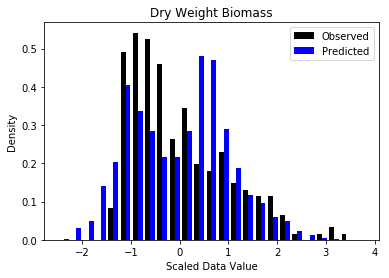

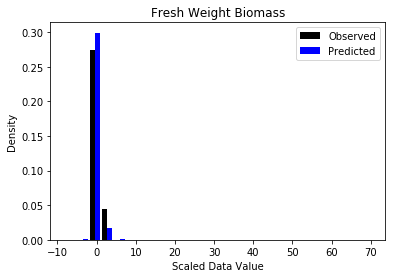

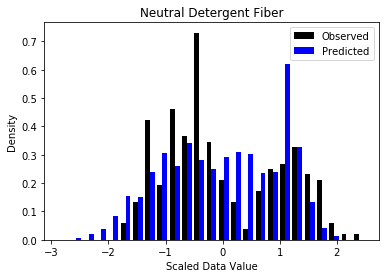

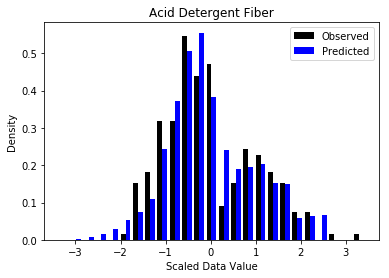

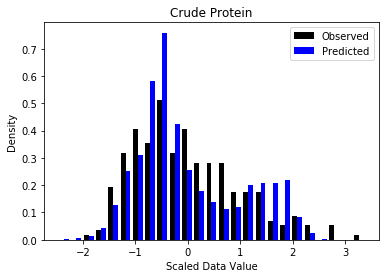

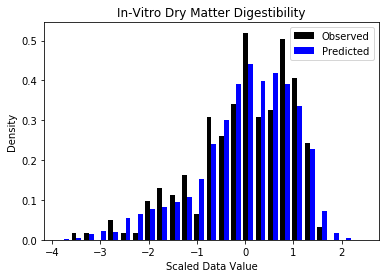

In [17]:
for var in fw_names:
  plot_hist(var)
  

In [0]:
descriptive = []
descriptive_fw = []

for i, var in enumerate(fw_names):
  describe = stats.describe(pred_pts[pred_names[i]])
  describe_fw = stats.describe(fw_pts[fw_names[i]])
  
  descriptive.append((var, describe.nobs, describe.minmax[0], describe.minmax[1], describe.mean, describe.variance, describe.skewness, describe.kurtosis))
  descriptive_fw.append((var, describe_fw.nobs, describe_fw.minmax[0], describe_fw.minmax[1], describe_fw.mean, describe_fw.variance, describe_fw.skewness, describe_fw.kurtosis))
  
  
descriptive_df = pd.DataFrame.from_dict(descriptive, orient='columns', dtype=None, columns=None)
descriptive_df.columns = ['var_name', 'n_obs', 'min', 'max', 'mean', 'variance', 'skewness', 'kurtosis']

descriptive_df_fw = pd.DataFrame.from_dict(descriptive_fw, orient='columns', dtype=None, columns=None)
descriptive_df_fw.columns = ['var_name', 'n_obs', 'min', 'max', 'mean', 'variance', 'skewness', 'kurtosis']

In [104]:
#There is an issue with the scaler
descriptive_df.head()

,var_name,n_obs,min,max,mean,variance,skewness,kurtosis
0,Dry_wgh,557317,0.133046,0.160392,0.143886,0.000019,0.146662,-0.556266
1,Frsh_wg,557317,-0.154262,4.907905,0.376500,0.004178,7.281895,184.213782
2,FDN,557317,432.072425,526.616301,482.779504,309.797084,-0.212391,-1.001413
3,FDA,557317,193.039657,288.020077,244.133541,227.711213,0.404097,-0.085160
4,CP,557317,13.286935,27.285749,19.663322,6.646372,0.622714,-0.709562


In [105]:
descriptive_df_fw.head()

,var_name,n_obs,min,max,mean,variance,skewness,kurtosis
0,Dry_wgh,242,0.013,0.428,0.130810,0.007076,0.978943,0.422141
1,Frsh_wg,242,0.047,1.150,0.376500,0.055298,0.923027,0.333122
2,FDN,242,55.930,81.190,66.703388,39.302596,0.384790,-1.063909
3,FDA,242,27.080,55.540,36.715537,30.338968,0.588310,-0.197902
4,CP,242,2.740,13.100,6.422851,3.928449,0.714992,0.137631


In [0]:
descriptive_df.to_csv('drive/My Drive/Pred_Descriptive_Stats.csv')

In [0]:
#no way of knowing if this is right or wrong
#could be the scaler, could be the veg type on the ground
